In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import one_hot_embedding
from torch.utils.data.sampler import SubsetRandomSampler
import time


%matplotlib inline

# Explore and clean the data
In this section, we want to explore the data and prepare for image classification. 

In [2]:
# create a df from styles.csv neglecting lines with error
DATASET_PATH = '/mnt/fashion-dataset-1/fashion-dataset/'
styles = pd.read_csv(os.path.join(DATASET_PATH, "styles.csv"), error_bad_lines=False) 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
print(styles.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [4]:
print(len(styles))

44424


In [5]:
# Get the list of names of images that are available
imgs_available = os.listdir(DATASET_PATH + '/images')
print(len(imgs_available))

44442


We want to check if each entry in styles.csv has a corresponding images listing. If not, we remove it from the dataframe.

In [6]:
# Check if each entry in styles.csv has a corresponding images listing. 
# If not, we remove it from the dataframe.
missing_img = []
for idx, line in styles.iterrows():
    if not os.path.exists(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg')):
        print(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg'))
        missing_img.append(idx)
        
styles.drop(styles.index[missing_img], inplace=True)

/mnt/fashion-dataset-1/fashion-dataset/images/39403.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39410.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39401.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39425.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/12347.jpg


In [7]:
print(len(styles))

44419


## Getting the top articleTypes 

In [8]:
# Check how many unique article types we have
uniquie_article_types = styles['articleType'].unique()
print(len(uniquie_article_types))

142


There are 142 distinct articleTypes. In the next cell we are going to see what are the top 20 of them.

In [9]:
top_classes = styles.groupby(['articleType']).size().nlargest(20).sort_values()
print(top_classes)

articleType
Jeans                     608
Perfume and Body Mist     613
Formal Shoes              637
Socks                     686
Backpacks                 724
Belts                     813
Briefs                    849
Sandals                   897
Flip Flops                914
Wallets                   936
Sunglasses               1073
Heels                    1323
Handbags                 1759
Tops                     1762
Kurtas                   1844
Sports Shoes             2036
Watches                  2542
Casual Shoes             2845
Shirts                   3215
Tshirts                  7066
dtype: int64


# Transfer Learning / Fine tuning

### Create master train and test splits of the valid image data, with everything in even years used for the training set, and everything in an odd year used for the test split.
Before doing that, we should check if there are any entries with not valid articleType or year and remove them

In [10]:
styles.dropna(inplace=True, subset=['year','articleType'])
len(styles)

44418

In [11]:
training_data = styles[styles['year'].astype('int') % 2 == 0]
test = styles[styles['year'].astype('int') % 2 == 1]

### Create sub-splits of the training data for pre-training and fine tuning 
We will do it as follows:
* the top 20 classes (see above) - about 3/4 of the data; and
* all other classes - about 1/4 of the data

In [12]:
top_classes_names = list(top_classes.index)

In [13]:
training_top20 = training_data[training_data.articleType.isin(top_classes_names)]
training_others = training_data[-training_data.articleType.isin(top_classes_names)]

### Creating Fashion Image Dataset class and constructing datasets and dataloaders

In [14]:
# Create a mapping between article types and their ids
cat_list = uniquie_article_types
cat2num = {cat:i for i, cat in enumerate(cat_list)}
num2cat = {i:cat for i, cat in enumerate(cat_list)}

In [15]:
# Create data transform
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [16]:
class FIDataset(Dataset):
    """ Fashion Image Dataset
    """
    
    def __init__(self, dir, dataframe, transform):
        super(FIDataset, self).__init__()
        self.dataframe = dataframe
        self.dir = dir
        self.transform = transform
        
    def __getitem__(self, idx):
        line = self.dataframe.iloc[idx]
        cat = line.articleType
        cat_id = cat2num[cat]
        img_path = os.path.join(self.dir, str(line.id)+'.jpg')
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)
        return img_tensor, cat_id
            
    def __len__(self):
        return len(self.dataframe)

In [17]:
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

In [18]:
# Construct datasets
top20_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_top20, transform)
others_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_others, transform)
test_data = FIDataset(os.path.join(DATASET_PATH, 'images'), test, transform)

In [19]:
def split_train_valid(train_data):
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler

In [20]:
# split the training data for each both 'top 20' and 'others' cases into train and validation datasets
top20_train_sampler, top20_valid_sampler = split_train_valid(top20_data)
others_train_sampler, others_valid_sampler = split_train_valid(others_data)

# prepare data loaders
top20_train_loader = DataLoader(top20_data, batch_size=batch_size, 
                                sampler=top20_train_sampler, num_workers=num_workers)
top20_valid_loader = DataLoader(top20_data, batch_size=batch_size, 
                                sampler=top20_valid_sampler, num_workers=num_workers)
others_train_loader = DataLoader(others_data, batch_size=batch_size, 
                                sampler=others_train_sampler, num_workers=num_workers)
others_valid_loader = DataLoader(others_data, batch_size=batch_size, 
                                sampler=others_valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualizing sample data from the training dataset

In [21]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [22]:
def plot_sample_data(dataloader, num):
    # obtain one batch of training images
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    # convert to numpy for display
    images = images.numpy() 
    labels = labels.numpy() 
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display images
    for idx in np.arange(num):
        ax = fig.add_subplot(1,5, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(num2cat[labels[idx]])

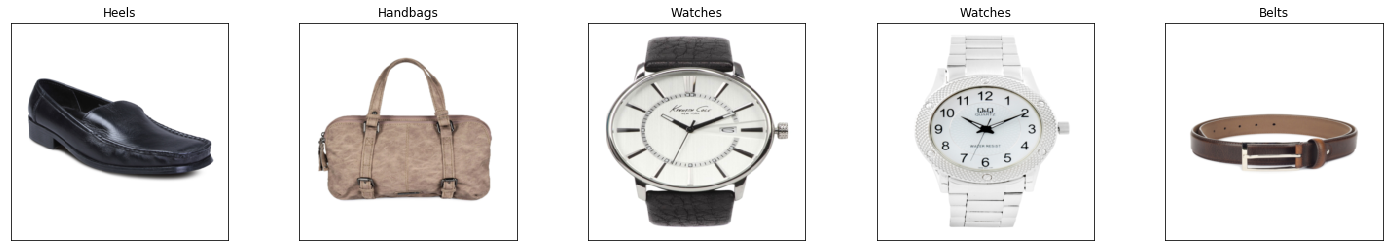

In [23]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(top20_train_loader,5)

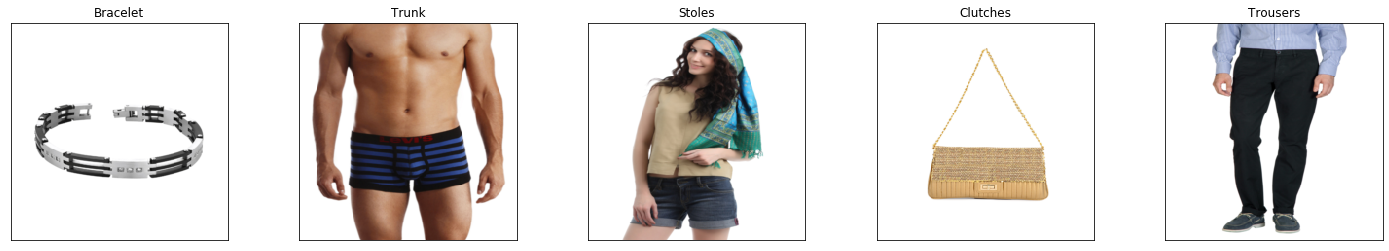

In [24]:
# Plot sample data from the training dataset of the remaining classes
plot_sample_data(others_train_loader,5)

### Train a classifier network using the top 20 classes by initializing from a pretrained network (we choose ResNet50 trained on ImageNet) and fine tuning the weights of the whole network.

In [25]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Specify model architecture 
model = models.resnet50(pretrained=True)

# To reshape the network, we reinitialize the classifier’s linear layer
n_inp = model.fc.in_features
model.fc = nn.Linear(n_inp, len(cat_list))

if use_cuda:
    model = model.cuda()

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): 
            self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): 
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

In [ ]:
# Taken from: https://github.com/kuangliu/pytorch-retinanet/blob/master/loss.py
class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)
    
    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [batch_size, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [batch_size, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [batch_size, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [batch_size, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets).
        '''
        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0  # [N,#anchors]
        num_pos = pos.data.long().sum()

        ################################################################
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        ################################################################
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos,4]
        masked_loc_targets = loc_targets[mask].view(-1,4)  # [#pos,4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, size_average=False)

        ################################################################
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        ################################################################
        pos_neg = cls_targets > -1  # exclude ignored anchors
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1,self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        loss = (loc_loss+cls_loss)/num_pos
        return loss

In [29]:
# Specify a loss function and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.fc.parameters(), lr=0.001)

In [31]:
n_epochs = 10

# train the model
model, train_loss_history, valid_loss_history = train(n_epochs, top20_train_loader, 
                                                      top20_valid_loader, model, optimizer, 
                                                      FocalLoss(), use_cuda, 'model2.pt')

/home/ubuntu/.local/share/virtualenvs/ubuntu-7Wf190Ea/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/9 	Training Loss: 2.090750 	Validation Loss: 1.241294
Validation loss decreased (inf --> 1.241294).  Saving model ...
Epoch: 2/9 	Training Loss: 1.106738 	Validation Loss: 0.842426
Validation loss decreased (1.241294 --> 0.842426).  Saving model ...
Epoch: 3/9 	Training Loss: 0.856781 	Validation Loss: 0.660958
Validation loss decreased (0.842426 --> 0.660958).  Saving model ...
Epoch: 4/9 	Training Loss: 0.726966 	Validation Loss: 0.571629
Validation loss decreased (0.660958 --> 0.571629).  Saving model ...
Epoch: 5/9 	Training Loss: 0.648720 	Validation Loss: 0.517676
Validation loss decreased (0.571629 --> 0.517676).  Saving model ...
Epoch: 6/9 	Training Loss: 0.598438 	Validation Loss: 0.475594
Validation loss decreased (0.517676 --> 0.475594).  Saving model ...
Epoch: 7/9 	Training Loss: 0.553122 	Validation Loss: 0.450218
Validation loss decreased (0.475594 --> 0.450218).  Saving model ...
Epoch: 8/9 	Training Loss: 0.530180 	Validation Loss: 0.436865
Validation loss de

In [32]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    since = time.time()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # initialize lists of values of train and valid losses over the training process
    train_loss_history = []
    valid_loss_history = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # record the average training loss and add it to history
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss_history.append(train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss and add it to history
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_loss_history.append(valid_loss)
            
        # Print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            n_epochs,
            train_loss,
            valid_loss
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            
    # Print training time        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # return trained model
    return model, train_loss_history, valid_loss_history

In [ ]:
n_epochs = 10

# train the model
model, train_loss_history, valid_loss_history = train(n_epochs, top20_train_loader, 
                                                      top20_valid_loader, model, optimizer, 
                                                      criterion, use_cuda, 'model.pt')

Epoch: 1/10 	Training Loss: 0.468815 	Validation Loss: 0.385020
Validation loss decreased (inf --> 0.385020).  Saving model ...
Epoch: 2/10 	Training Loss: 0.454376 	Validation Loss: 0.374869
Validation loss decreased (0.385020 --> 0.374869).  Saving model ...
Epoch: 3/10 	Training Loss: 0.439237 	Validation Loss: 0.366538
Validation loss decreased (0.374869 --> 0.366538).  Saving model ...
Epoch: 4/10 	Training Loss: 0.434550 	Validation Loss: 0.354954
Validation loss decreased (0.366538 --> 0.354954).  Saving model ...
Epoch: 5/10 	Training Loss: 0.421636 	Validation Loss: 0.361680
Epoch: 6/10 	Training Loss: 0.411436 	Validation Loss: 0.348074
Validation loss decreased (0.354954 --> 0.348074).  Saving model ...
Epoch: 7/10 	Training Loss: 0.407310 	Validation Loss: 0.339639
Validation loss decreased (0.348074 --> 0.339639).  Saving model ...
Epoch: 8/10 	Training Loss: 0.404735 	Validation Loss: 0.340570
Epoch: 9/10 	Training Loss: 0.394333 	Validation Loss: 0.331131
Validation loss

In [ ]:
# Define a helper function for plotting training and valid loss
def plot_training_and_valid_loss(train_loss, valid_loss):
    plt.title("Training and Validation Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1),ohist,label="Training Loss")
    plt.plot(range(1,n_epochs+1),shist,label="Validation Loss")
    plt.xticks(np.arange(1, n_epochs+1, 1.0))
    plt.legend()
    plt.show()
    
plot_training_and_valid_loss(train_loss_history, valid_loss_history)

In [ ]:
def test(test_loader, model, criterion, use_cuda):

    # Define variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # Put the model in eval mode
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # If GPU available, move data and targets to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Compute predicted outputs by passing inputs to the model (forward pass)
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average test loss 
        test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions with true labels
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    return test_loss, correct, total

test_loss, correct, total = test(test_loader, model, criterion, use_cuda)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))